In [5]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [7]:
class RNN(nn.Module):
    # they already have RNN module, but we are gonna implement it.
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)

        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
category_lines, all_categories = load_data()
n_category = len(all_categories)
print(n_category)

18


In [9]:
n_hidden = 128 # hyperparameter
rnn = RNN(N_LETTERS, n_hidden, n_category)

In [10]:
input_tensor = letter_to_tensor("A")
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [11]:
# whole sequence / name
input_tensor = line_to_tensor("Albert")
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [12]:
# let's define a function
#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [13]:

category_from_output(output)       

'French'

In [14]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) # will be returning new hidden state from previous hidden state and input
    

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [15]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

4999 4.999 2.7951 Ferreira / Greek WRONG (Portuguese)
9999 9.998999999999999 2.8370 De filippis / Greek WRONG (Italian)
14999 14.999 1.3548 Hung / Chinese WRONG (Korean)
19999 19.999 2.7678 Gray / Vietnamese WRONG (Scottish)
24999 24.999 1.8495 Sala / Spanish CORRECT
29999 29.999 2.1563 Goddard / French WRONG (English)
34999 34.999 2.0575 Macclelland / English WRONG (Irish)
39999 39.999 1.8177 Wehunt / German CORRECT
44999 44.999 0.6757 Kosmatka / Polish CORRECT
49999 49.999 1.0826 Amari / Arabic CORRECT
54999 54.998999999999995 0.0654 Kalakos / Greek CORRECT
59999 59.999 0.2105 Lindsay / Scottish CORRECT
64999 64.999 0.1523 Matsoukis / Greek CORRECT
69999 69.999 0.2069 Ying / Chinese CORRECT
74999 74.99900000000001 0.2597 Kassis / Arabic CORRECT
79999 79.999 0.5883 Zhi / Chinese CORRECT
84999 84.999 5.2600 Quinn / Vietnamese WRONG (Irish)
89999 89.999 0.0020 Makhachev / Russian CORRECT
94999 94.999 2.2533 Mcavoy / French WRONG (English)
99999 99.99900000000001 0.0961 Glynatsis / Greek

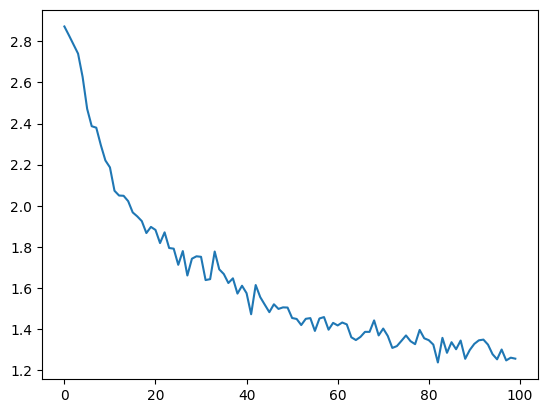

In [18]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [21]:
import torch

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

predict("Abba delli")


> Abba delli
Italian


In [24]:
predict("siksa")


> siksa
Japanese


In [26]:
predict("hello, worlds")


> hello, worlds
English
